### **Install / Import required package**

In [1]:
%%sh
http_proxy=http://10.245.5.249:8080
export http_proxy
https_proxy=https://10.245.5.249:8080
export https_proxy

pip install gcsfs
pip install factor_analyzer
pip install hdbscan
# pip install numpy==1.16.1
pip install seaborn --upgrade

  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-py3-none-any.whl size=40380 sha256=881d5fa399abae87570a175829474684259f796c5cc9814790258d5c3f73618f
  Stored in directory: /root/.cache/pip/wheels/eb/fa/90/032dca854f9faf31265c49d06c3f6eae3ede56cca623f8a27e
Successfully built factor-analyzer
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached numpy-1.19.0-cp36-cp36m-manylinux2010_x86_64.whl (14.6 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2470160 sha256=fec17449ffc4333a9761fdf311b59db94e8fb9b730fd2b1ee24313ceb71e540a
  Stored in directory: /root/.cache/pip/wheels/36/20/d1/521b2fbf637de5bc40668b6445944e7e44bfbe68fdaa65157d
Successfully built hdbscan
  At

In [2]:
import csv
import math
import warnings
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
from sklearn.decomposition import PCA 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.metrics import silhouette_score 
import scipy.cluster.hierarchy as shc

In [4]:
# df_ws = pd.read_csv('gs://aes-datahub-0001-raw/Weather/Weather_Source/USA/Indianapolis/Historical_Data/Storm_Data_2007-2019/Weather_Source_All_Marker.csv', index_col=0)
# print(df_ws.shape)

In [5]:
df_ws_v1 = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Test/Weather_Source_Data.csv', index_col=0)
print(df_ws_v1.shape)

(8500, 29)


In [6]:
df_ws_v1.head()

,cldCvrAvg,cldCvrMax,cldCvrMin,precip,presTendAvg,presTendMax,presTendMin,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,tempAvg,tempMax,tempMin,windDirAvg,windSpdAvg,windSpdMax,windSpdMin,presTendRange,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio
0,69,100,6,0.82,-0.70,0.20,-3.00,79.30,87.30,67.30,988.70,995.20,977.50,0.10,30.10,38.20,21.40,109,19.90,29.90,13.10,3.20,16.80,16.80,17.70,94,20.00,1.30,1.02
1,45,100,1,0.16,-0.20,1.20,-2.20,65.00,79.30,47.10,981.90,986.40,977.20,0.00,65.40,77.70,49.30,213,15.50,21.50,9.10,3.40,28.40,12.40,9.20,99,32.20,1.68,1.01
2,93,100,60,0.92,-0.50,1.10,-2.00,78.00,89.10,65.00,970.80,980.50,964.80,0.00,46.60,56.90,38.70,143,15.40,21.10,10.60,3.10,18.20,10.50,15.70,40,24.10,1.37,1.02
3,13,32,2,0.00,-0.30,0.00,-1.20,53.70,73.60,32.00,982.40,985.40,979.00,0.00,76.80,88.20,66.30,211,5.90,12.00,1.90,1.20,21.90,10.10,6.40,30,41.60,2.30,1.01
4,41,90,9,0.02,-0.30,0.50,-0.90,65.00,84.90,46.00,974.50,978.70,971.90,0.00,72.00,80.60,66.40,236,4.70,11.90,0.30,1.40,14.20,11.60,6.80,81,38.90,1.85,1.01


## Check NA's and remove unnecessary columns

In [7]:
print(df_ws_v1.isnull().sum())
# df_ws.drop(['timestamp'],axis=1,inplace=True)

cldCvrAvg        0
cldCvrMax        0
cldCvrMin        0
precip           0
presTendAvg      0
presTendMax      0
presTendMin      0
relHumAvg        0
relHumMax        0
relHumMin        0
sfcPresAvg       0
sfcPresMax       0
sfcPresMin       0
snowfall         0
tempAvg          0
tempMax          0
tempMin          0
windDirAvg       0
windSpdAvg       0
windSpdMax       0
windSpdMin       0
presTendRange    0
tempRange        0
windSpdRange     0
sfcPresRange     0
cldCvrRange      0
relHumRange      0
relHumRatio      0
sfcPresRatio     0
dtype: int64


# Preprocessing the data

#### Z score normalization of data 
In statistics, the standard score is the number of standard deviations by which the value of a raw score is above or below the mean value of what is being observed or measured.<br>
Raw scores above the mean have positive standard scores, while those below the mean have negative standard scores.<br>

In [8]:
# Note that `select_dtypes` returns a data frame. We are selecting only the columns
from scipy.stats import zscore
numeric_cols = df_ws_v1.select_dtypes(include=[np.number]).columns
df_ws_zscore = df_ws_v1[numeric_cols].apply(zscore)
# df_ws_zscore = df_ws_v1.copy(deep=True)

In [9]:
df_ws_zscore.head()

,cldCvrAvg,cldCvrMax,cldCvrMin,precip,presTendAvg,presTendMax,presTendMin,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,tempAvg,tempMax,tempMin,windDirAvg,windSpdAvg,windSpdMax,windSpdMin,presTendRange,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio
0,0.31,0.38,-0.48,0.73,-2.26,-1.73,-1.78,0.08,-0.98,0.54,0.73,1.21,-0.32,0.11,-1.71,-1.73,-1.70,-1.39,3.04,2.61,3.75,0.11,-0.12,1.15,1.77,0.68,-1.09,-0.89,1.76
1,-0.53,0.38,-0.63,-0.47,-0.74,-0.47,-0.85,-1.29,-2.18,-0.82,-0.31,-0.21,-0.36,-0.14,0.22,0.37,-0.21,-0.03,1.94,1.22,2.30,0.26,1.77,0.21,0.25,0.83,-0.18,-0.00,0.25
2,1.16,0.38,1.21,0.91,-1.65,-0.60,-0.62,-0.05,-0.71,0.39,-2.01,-1.16,-2.02,-0.14,-0.81,-0.74,-0.77,-0.95,1.91,1.15,2.84,0.04,0.11,-0.19,1.42,-0.95,-0.79,-0.72,1.44
3,-1.66,-3.22,-0.60,-0.76,-1.04,-1.98,0.31,-2.37,-3.04,-1.83,-0.24,-0.37,-0.12,-0.14,0.84,0.93,0.70,-0.05,-0.46,-0.36,-0.31,-1.35,0.71,-0.28,-0.25,-1.26,0.52,1.42,-0.25
4,-0.67,-0.15,-0.38,-0.73,-1.04,-1.35,0.66,-1.29,-1.34,-0.89,-1.45,-1.45,-1.07,-0.14,0.58,0.52,0.70,0.28,-0.76,-0.37,-0.89,-1.21,-0.54,0.04,-0.18,0.29,0.32,0.37,-0.17


In [10]:
# list_of_columns = list(df_ws_zscore.columns)
# df_ws_zscore[list_of_columns] = df_ws_zscore[list_of_columns].astype(np.int64)
print(df_ws_zscore.dtypes)

cldCvrAvg        float64
cldCvrMax        float64
cldCvrMin        float64
precip           float64
presTendAvg      float64
presTendMax      float64
presTendMin      float64
relHumAvg        float64
relHumMax        float64
relHumMin        float64
sfcPresAvg       float64
sfcPresMax       float64
sfcPresMin       float64
snowfall         float64
tempAvg          float64
tempMax          float64
tempMin          float64
windDirAvg       float64
windSpdAvg       float64
windSpdMax       float64
windSpdMin       float64
presTendRange    float64
tempRange        float64
windSpdRange     float64
sfcPresRange     float64
cldCvrRange      float64
relHumRange      float64
relHumRatio      float64
sfcPresRatio     float64
dtype: object


## Correlation Matrix 
A correlation matrix is a table showing correlation coefficients between variables. <br>
Each cell in the table shows the correlation between two variables. <br>
A correlation matrix is used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses. <br>

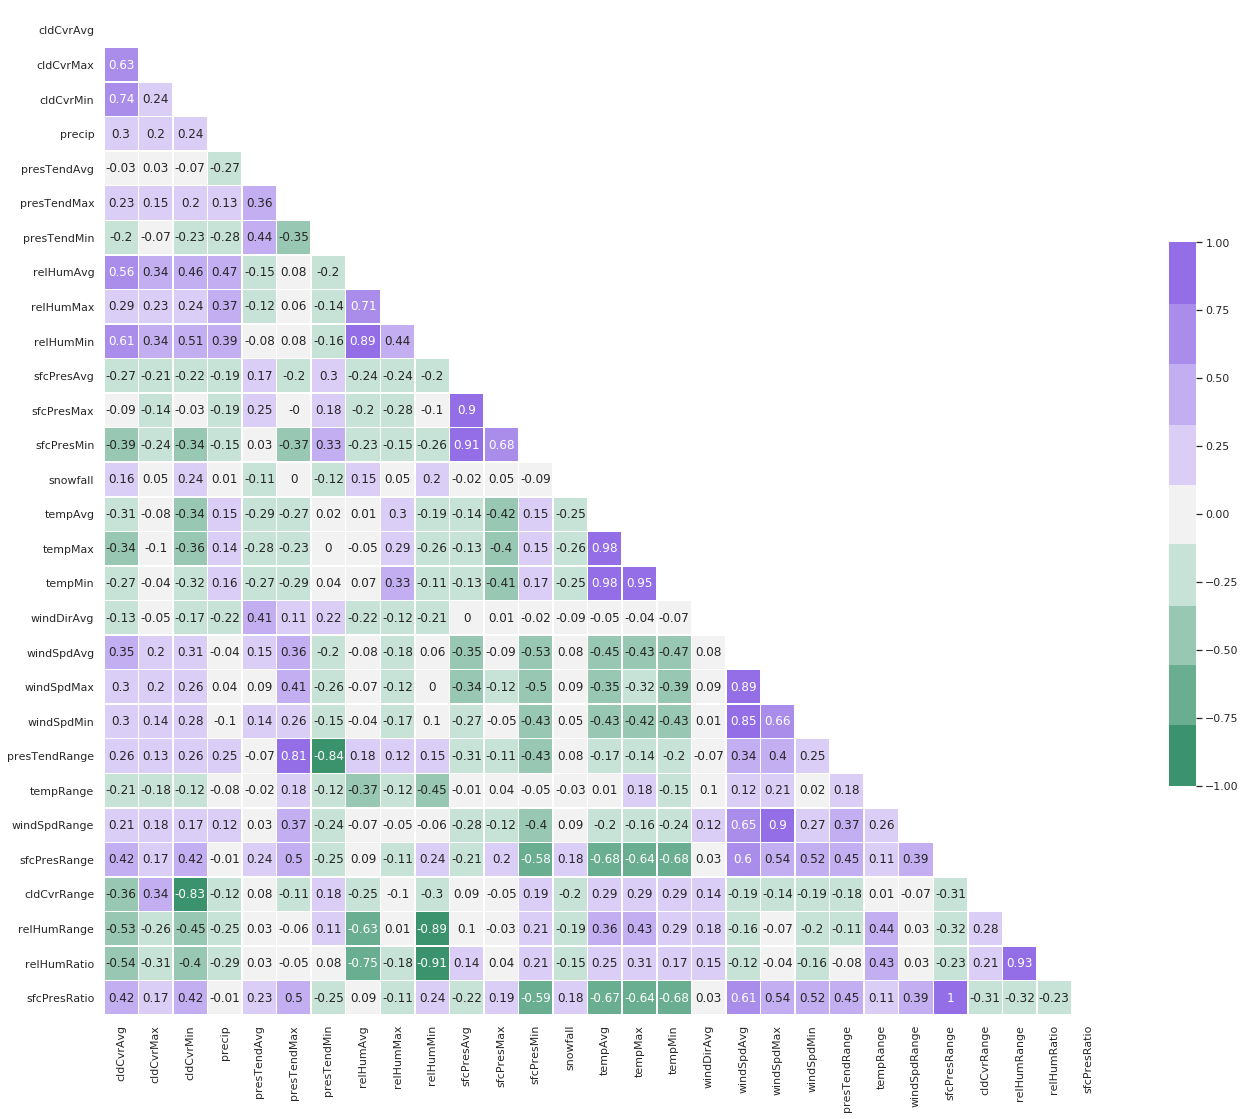

In [11]:
sns.set(style="white")

# Compute the correlation matrix
corr = df_ws_zscore.corr()
corr = corr.round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
# cmap = sns.diverging._palette(220, 10, as_cmap=True)
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot = True, vmin=-1)

In [12]:
print(list(df_ws_zscore.columns))

['cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'precip', 'presTendAvg', 'presTendMax', 'presTendMin', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowfall', 'tempAvg', 'tempMax', 'tempMin', 'windDirAvg', 'windSpdAvg', 'windSpdMax', 'windSpdMin', 'presTendRange', 'tempRange', 'windSpdRange', 'sfcPresRange', 'cldCvrRange', 'relHumRange', 'relHumRatio', 'sfcPresRatio']


Selecting **cldCvrAvg, precip, presTendAvg, relHumAvg, sfcPresMax, snowfall, tempMax, windDirAvg, windSpdMin, tempRange, windSpdRange**

In [13]:
# Subset for necessary columns 

# df_ws_v2 = df_ws_zscore[['cldCvrAvg', 'precip', 'presTendAvg', 'relHumAvg', 'sfcPresMax', 'snowfall', 'tempMax', 'windDirAvg', 'windSpdMin', 'tempRange', 'windSpdRange']]
df_ws_v2 = df_ws_v1.copy(deep=True)

In [14]:
df_ws_v2.head()

,cldCvrAvg,cldCvrMax,cldCvrMin,precip,presTendAvg,presTendMax,presTendMin,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,tempAvg,tempMax,tempMin,windDirAvg,windSpdAvg,windSpdMax,windSpdMin,presTendRange,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio
0,69,100,6,0.82,-0.70,0.20,-3.00,79.30,87.30,67.30,988.70,995.20,977.50,0.10,30.10,38.20,21.40,109,19.90,29.90,13.10,3.20,16.80,16.80,17.70,94,20.00,1.30,1.02
1,45,100,1,0.16,-0.20,1.20,-2.20,65.00,79.30,47.10,981.90,986.40,977.20,0.00,65.40,77.70,49.30,213,15.50,21.50,9.10,3.40,28.40,12.40,9.20,99,32.20,1.68,1.01
2,93,100,60,0.92,-0.50,1.10,-2.00,78.00,89.10,65.00,970.80,980.50,964.80,0.00,46.60,56.90,38.70,143,15.40,21.10,10.60,3.10,18.20,10.50,15.70,40,24.10,1.37,1.02
3,13,32,2,0.00,-0.30,0.00,-1.20,53.70,73.60,32.00,982.40,985.40,979.00,0.00,76.80,88.20,66.30,211,5.90,12.00,1.90,1.20,21.90,10.10,6.40,30,41.60,2.30,1.01
4,41,90,9,0.02,-0.30,0.50,-0.90,65.00,84.90,46.00,974.50,978.70,971.90,0.00,72.00,80.60,66.40,236,4.70,11.90,0.30,1.40,14.20,11.60,6.80,81,38.90,1.85,1.01


## VIF
In statistics, the variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone.[1] It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity. Cuthbert Daniel claims to have invented the concept behind the variance inflation factor, but did not come up with the name.

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(df_ws_v2)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
type(vif)
df_vif = pd.DataFrame({'Feature': vif.index, 'VIF_SCORES': vif.values})
df_vif[df_vif.VIF_SCORES<=10]

,Feature,VIF_SCORES
1,cldCvrAvg,5.23
4,precip,1.57
5,presTendAvg,2.55
14,snowfall,1.19
18,windDirAvg,1.33


## Factor Analysis 
Factor analysis is a technique that is used to reduce a large number of variables into fewer numbers of factors. <br>
This technique extracts maximum common variance from all variables and puts them into a common score. <br>
As an index of all variables, we can use this score for further analysis. <br>

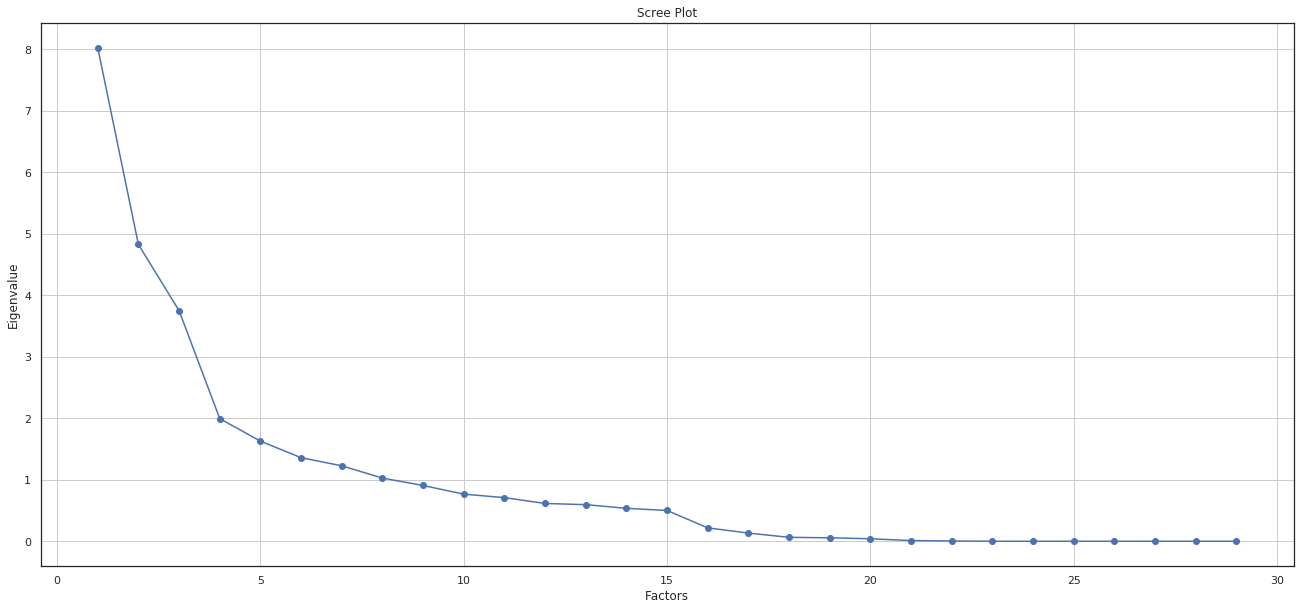

In [16]:
#Subset of the data, the 14 columns containing the survey answers
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer()
fa.set_params(n_factors=10, rotation=None)
fa.fit(df_ws_v2)
ev, v = fa.get_eigenvalues()

plt.figure(figsize=(20,10))
plt.scatter(range(1,df_ws_v2.shape[1]+1),ev)
plt.plot(range(1,df_ws_v2.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

We will only use 5 factors here, given the big dropoff in eigenvalue after the 5th factor. <br>
https://towardsdatascience.com/factor-analysis-a-complete-tutorial-1b7621890e42 <br>

In [17]:
name_features = list(df_ws_v2.columns)
factors_df = pd.DataFrame()
factors_df['Features'] = name_features

In [18]:
fa = FactorAnalyzer(4, rotation='varimax')
fa.fit(df_ws_v2)
loads = fa.loadings_
# print(loads)
factors_df['Factor1'] = loads[:,0:1]
factors_df['Factor2'] = loads[:,1:2]
factors_df['Factor3'] = loads[:,2:3]
factors_df['Factor4'] = loads[:,3:4]
# factors_df['Factor5'] = loads[:,4:5]
# factors_df['Factor6'] = loads[:,5:6]
# factors_df['Factor7'] = loads[:,6:7]

In [19]:
factors_df

,Features,Factor1,Factor2,Factor3,Factor4
0,cldCvrAvg,0.24,0.66,0.29,0.18
1,cldCvrMax,0.02,0.35,0.27,0.00
2,cldCvrMin,0.29,0.56,0.18,0.29
3,precip,-0.24,0.40,0.05,0.32
4,presTendAvg,0.37,-0.14,0.04,-0.23
5,presTendMax,0.29,-0.01,0.29,0.51
6,presTendMin,0.06,-0.12,-0.17,-0.77
7,relHumAvg,-0.17,0.90,0.02,0.17
8,relHumMax,-0.40,0.42,0.05,0.21
9,relHumMin,0.07,0.98,0.04,0.05


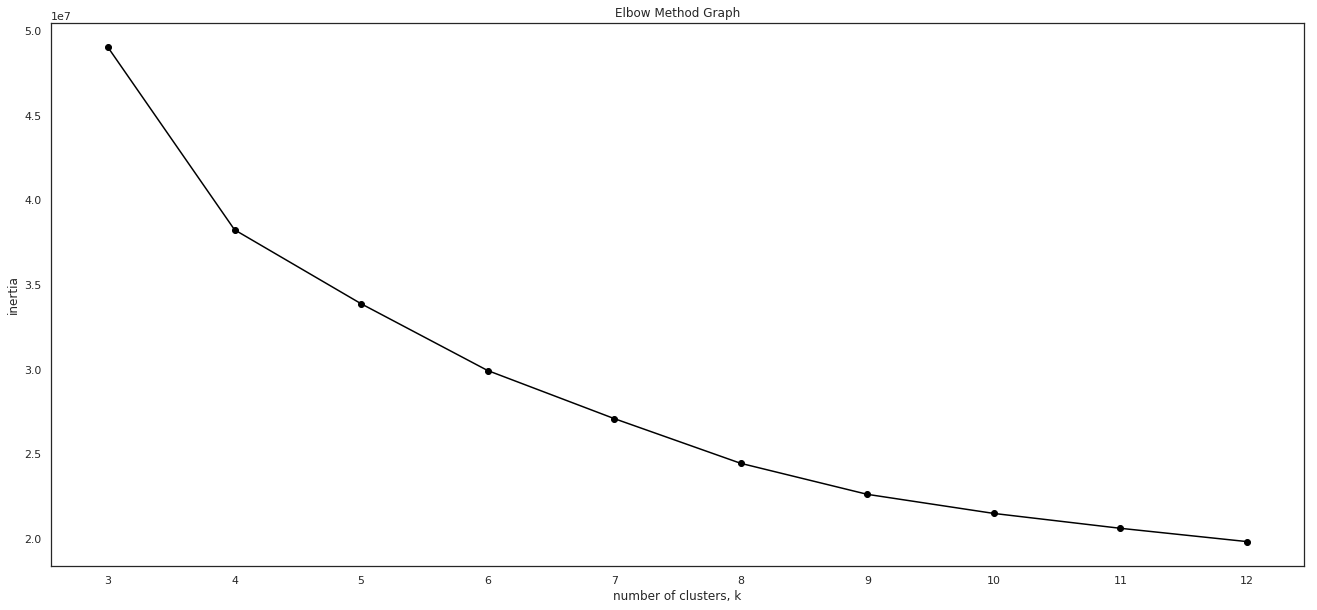

In [20]:
## Kmeans 
from sklearn.cluster import KMeans

ks = range(3, 13)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_ws_v2.iloc[:,:])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.figure(figsize=(20,10))
plt.title('Elbow Method Graph')
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### **The Silhouette Method**
The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

In [21]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 12

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(df_ws_v2)
    labels = kmeans.labels_
    score = silhouette_score(df_ws_v2, labels, metric = 'euclidean')
    sil.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(k, round(score,4)))

For n_clusters = 2, silhouette score is 0.3903)
For n_clusters = 3, silhouette score is 0.2696)
For n_clusters = 4, silhouette score is 0.3025)
For n_clusters = 5, silhouette score is 0.3135)
For n_clusters = 6, silhouette score is 0.3273)
For n_clusters = 7, silhouette score is 0.3044)
For n_clusters = 8, silhouette score is 0.2995)
For n_clusters = 9, silhouette score is 0.2481)
For n_clusters = 10, silhouette score is 0.2364)
For n_clusters = 11, silhouette score is 0.2374)
For n_clusters = 12, silhouette score is 0.2379)


## Partitional Kmeans
Some things to take note of though: <br>

k-means clustering is very sensitive to scale due to its reliance on Euclidean distance so be sure to normalize data if there are likely to be scaling problems. <br>
If there are some symmetries in your data, some of the labels may be mis-labelled <br>
It is recommended to do the same k-means with different initial centroids and take the most common label. <br>

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_ws_v2)

labels_ = kmeans.predict(df_ws_v2)
centroids = kmeans.cluster_centers_

In [32]:
label_list = labels_.tolist()

In [33]:
df_ws_v1['kmeans5_labels'] = label_list

In [34]:
print(df_ws_v1.kmeans5_labels.value_counts())

0    3591
4    2484
3    1214
1     607
2     604
Name: kmeans5_labels, dtype: int64


In [35]:
print(df_ws_v1.kmeans6_labels.value_counts())

1    3523
2    2051
5    1201
0     604
3     601
4     520
Name: kmeans6_labels, dtype: int64


In [29]:
df_ws_v1.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Test/kmeans_clsuter_07212020.csv')

In [24]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=1333, min_samples=1000)
clusterer.fit(df_ws_v2)

# HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
#     gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
#     metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_epsilon=0.0,
    cluster_selection_method='eom', core_dist_n_jobs=4,
    gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=1333, min_samples=1000, p=None,
    prediction_data=False)

In [25]:
clusterer.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [26]:
clusterer.labels_.max()

-1

In [27]:
clusterer.probabilities_

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
clusterer.condensed_tree_

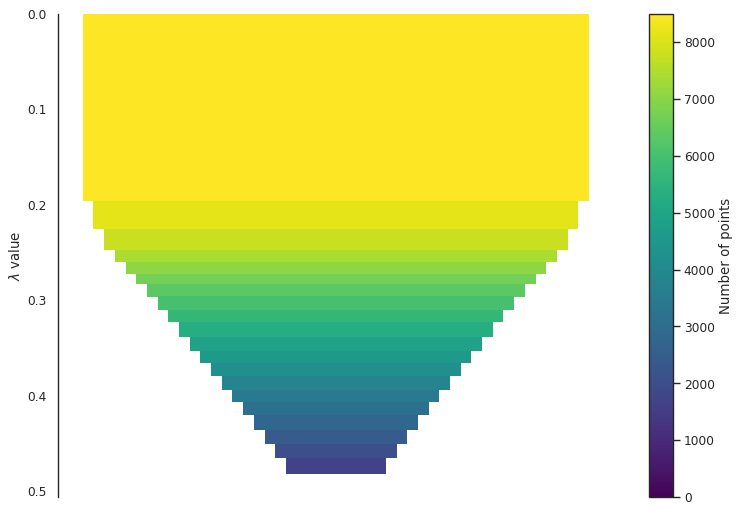

In [29]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
clusterer.condensed_tree_.plot()

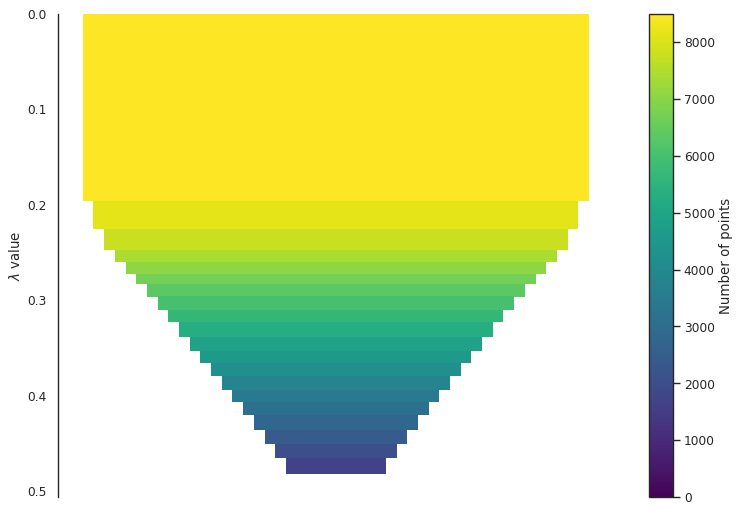

In [30]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
clusterer.condensed_tree_.plot(select_clusters=True,selection_palette=sns.color_palette('deep', 8))

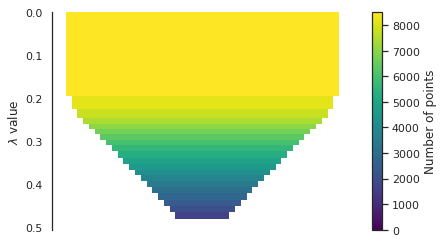

In [31]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [32]:
clusterer.condensed_tree_.to_networkx()
g = clusterer.condensed_tree_.to_networkx()
g.number_of_nodes()

8501

In [33]:
clusterer.condensed_tree_.to_pandas().head()

,parent,child,lambda_val,child_size
0,8500,6074,0.06,1
1,8500,5166,0.06,1
2,8500,124,0.07,1
3,8500,4374,0.07,1
4,8500,6499,0.07,1


In [34]:
tree = clusterer.condensed_tree_.to_pandas()
cluster_tree = tree[tree.child_size > 1]
clusterer.condensed_tree_.to_numpy()

array([(8500, 6074, 0.06376983, 1), (8500, 5166, 0.06453523, 1),
       (8500,  124, 0.06527479, 1), ..., (8500, 7277, 0.48195136, 1),
       (8500, 4302, 0.48195136, 1), (8500, 2177, 0.48195136, 1)],
      dtype=[('parent', '<i8'), ('child', '<i8'), ('lambda_val', '<f8'), ('child_size', '<i8')])

In [35]:
# single linkage tree 
clusterer.single_linkage_tree_
clusterer.single_linkage_tree_.plot()

RecursionError: maximum recursion depth exceeded while getting the str of an object

In [36]:
clusterer.single_linkage_tree_.get_clusters(0.023, min_cluster_size=2)

array([-1, -1, -1, ..., -1, -1, -1])

In [37]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

RecursionError: maximum recursion depth exceeded while getting the str of an object

## Outlier Detection
The hdbscan library supports the GLOSH outlier detection algorithm, and does so within the HDBSCAN clustering class. <br>
The GLOSH outlier detection algorithm is related to older outlier detection methods such as LOF and LOCI. <br>
It is a fast and flexible outlier detection system, and supports a notion of local outliers. <br>
This means that it can detect outliers that may be noticeably different from points in its local region (for example points not on a local submanifold) but that are not necessarily outliers globally. <br>

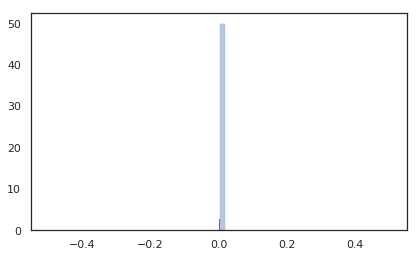

In [38]:
# Outlier detection 
clusterer.outlier_scores_
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

In [40]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*df_ws_v2.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*df_ws_v2[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)

TypeError: scatter() got multiple values for argument 's'

In [ ]:
# # Scaling the data so that all the features become comparable 
# scaler = StandardScaler() 
# X_scaled = scaler.fit_transform(df_ws) 
  
# # Normalizing the data so that the data approximately  
# # follows a Gaussian distribution 
# X_normalized = normalize(X_scaled) 
  
# # Converting the numpy array into a pandas DataFrame 
# X_normalized = pd.DataFrame(X_normalized) 

In [ ]:
# ### PCA 
# PCA is essentially a method that reduces the dimension of the feature space in such a way that new variables are orthogonal to each other (i.e. they are independent or not correlated)

# pca = PCA(n_components = 2)

# X_principal = pca.fit_transform(X_normalized) 
# X_principal = pd.DataFrame(X_principal) 
# X_principal.columns = ['P1', 'P2'] 

# ## Choosing the number of compnents

# A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. <br>
# This can be determined by looking at the cumulative explained variance ratio as a function of the number of components: <br>

# from matplotlib.pyplot import figure
# figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

# # Choosing number of components 
# pca = PCA().fit(X_normalized)
# plt.title("Choose number of PCA components")
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

# # Create a PCA instance: pca
# pca = PCA(n_components=11)
# principalComponents = pca.fit_transform(X_normalized)

# # Plot the explained variances
# features = range(pca.n_components_)
# plt.bar(features, pca.explained_variance_ratio_, color='black')
# plt.xlabel('PCA features')
# plt.ylabel('variance %')
# plt.xticks(features)

# # Save components to a DataFrame
# PCA_components = pd.DataFrame(principalComponents)
# PCA_components.columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11']

# Dendograms are used to divide a given cluster into many different clusters

## Visualizing the working of the Dendograms

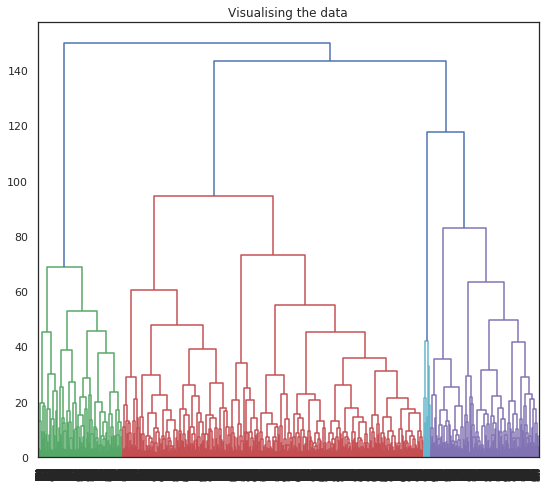

In [41]:
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(df_ws_v2, method ='ward')))

### The above image shows optimal number of clusters should be five for the data 

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_ws_v2, method='ward'))

# Building and Visualizing the different clustering models for different values of k

## a. k=2

In [ ]:
ac2 = AgglomerativeClustering(n_clusters = 2, affinity='euclidean', linkage='ward')
  
# Visualizing the clustering 
plt.figure(figsize =(6, 6)) 
plt.scatter(df_ws_v2['P1'], PCA_components['P2'], c = ac2.fit_predict(PCA_components), cmap ='rainbow') 
plt.show()

## b. k=3

In [ ]:
ac3 = AgglomerativeClustering(n_clusters = 3, affinity='euclidean', linkage='ward')
  
plt.figure(figsize =(6, 6)) 
plt.scatter(PCA_components['P1'], PCA_components['P2'], c = ac3.fit_predict(PCA_components), cmap ='rainbow') 
plt.show()

# c. k=4

In [ ]:
ac4 = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='ward')
  
plt.figure(figsize =(6, 6)) 
plt.scatter(PCA_components['P1'], PCA_components['P2'], 
            c = ac4.fit_predict(PCA_components), cmap ='rainbow') 
plt.show() 

## d. k = 5

In [ ]:
ac5 = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage='ward')
  
plt.figure(figsize =(6, 6)) 
plt.scatter(PCA_components['P1'], PCA_components['P2'], 
            c = ac5.fit_predict(PCA_components), cmap ='rainbow') 
plt.show() 

# e. k = 6

In [ ]:
ac6 = AgglomerativeClustering(n_clusters = 6,affinity='euclidean', linkage='ward')
  
plt.figure(figsize =(6, 6)) 
plt.scatter(PCA_components['P1'], PCA_components['P2'], 
            c = ac6.fit_predict(PCA_components), cmap ='rainbow') 
plt.show()

# Evaluating the different models and Visualizing the results.

In [ ]:
k = [2, 3, 4, 5, 6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
        silhouette_score(PCA_components, ac2.fit_predict(PCA_components))) 
silhouette_scores.append( 
        silhouette_score(PCA_components, ac3.fit_predict(PCA_components))) 
silhouette_scores.append( 
        silhouette_score(PCA_components, ac4.fit_predict(PCA_components))) 
silhouette_scores.append( 
        silhouette_score(PCA_components, ac5.fit_predict(PCA_components))) 
silhouette_scores.append( 
        silhouette_score(PCA_components, ac6.fit_predict(PCA_components))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 

Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified. <br>

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. <br>

The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance. <br>

## Saving model objects using pickle 

In [ ]:
import pickle
pickle.dump(ac6, open("agglomerativemodel6.pkl", "wb"))

# Thus, with the help of the silhouette scores, it is concluded that the optimal number of clusters for the given data and clustering technique is 6.